In [1]:
# Importing pandas and numpy library
import pandas as pd
import numpy as np

# Loading in data frame
df = pd.read_csv('df.csv')

# Deleting unnecessary column and symbolizing all non-diabetic records with 0 instead of 3.
del df['Unnamed: 0']
df['diabetes_status'] = df['diabetes_status'].replace(3,0)

# Isolating target variable. 
df_target = df['diabetes_status']
del df['diabetes_status']

# Importing functions to split up and transform our data.
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Creating lists to contain the continuous variable names and the discrete variable names.
cont = ['age','height_inches','bmi']
disc = ['general_health', 'physical_health_days', 'mental_health_days',
       'has_health_plan', 'meets_aerobic_guidelines',
       'physical_activity_150min', 'muscle_strengthening',
       'high_blood_pressure', 'high_cholesterol', 'heart_disease',
       'lifetime_asthma', 'arthritis', 'sex', 
       'education_level', 'income_group', 'smoking_status',
       'alcohol_consumption', 'binge_drinking', 'heavy_drinking',
       'difficulty_walking']

# Splitting up predictor and target variable into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(df, df_target, test_size=0.30, random_state=22, stratify=df_target)
# Utilizing stratify parameters helps ensure that the percentage or diabetic and non-diabetic individuals are around the same in the training and tests sets.

# Creating pipeline to logarithmically transform and min max scale all continuous variables.
cont_pipeline = Pipeline([
    ('log', FunctionTransformer(func=np.log1p)),
    ('scaler', StandardScaler()),
    ])

# Creating pipeline to one hot encode all discrete variables while dropping the first.
disc_pipeline = Pipeline([
    ('one_hot', OneHotEncoder(sparse_output=False, drop='first')),
    ('scaler', StandardScaler()),
])

# Creating a column transform to send all discrete variable to disc_pipeline and all continuous variables to cont_pipeline.
column_transformer = ColumnTransformer([
    ('cont', cont_pipeline, cont),
    ('disc', disc_pipeline, disc),
])

# Fitting column transform with training data and then transforming training data using the fitted column transformer.
X_train1 = column_transformer.fit_transform(X_train)
# Transforming testing data using the fitted column transform.
X_test1 = column_transformer.transform(X_test)

# Creating data frames based on X_train1 and X_test1 for feature importance analysis later one.
X_train1 = pd.DataFrame(X_train1)
X_test1 = pd.DataFrame(X_test1)

## Model Building

### HistGradientBoostingClassifier

In [8]:
# Importing HistGradientBoostingClassifier function.
from sklearn.ensemble import HistGradientBoostingClassifier

# Importing confusion_matrix function, classification_report function, and ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Importing matplotlib.pyplot
import matplotlib.pyplot as plt

#### Training HistGradientBoostingClassifier

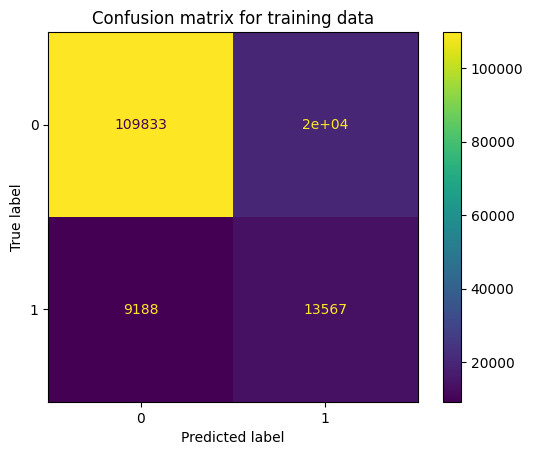

Classification report for training data is below:
              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88    129831
         1.0       0.40      0.60      0.48     22755

    accuracy                           0.81    152586
   macro avg       0.66      0.72      0.68    152586
weighted avg       0.85      0.81      0.82    152586



In [3]:
# Creating a HistGradientBoostingClassifier model, hgbc, with the best parameters determined from the best HistGradientBoostingClassifier model in 'a second attempt.ipynb'.
hgbc = HistGradientBoostingClassifier(random_state=42, min_samples_leaf=5, max_leaf_nodes=15,
                                      max_iter=100, max_depth=20, learning_rate=.1,
                                      l2_regularization=0.5, class_weight={0:1, 1:3})
# Fitting hgbc with training data.
hgbc.fit(X_train1, y_train)

# Below lines of code display the confusion matrix and classification report for the hgbc model when tested with the training data.
train_pred_target = hgbc.predict(X_train1)
ConfusionMatrixDisplay(confusion_matrix(y_train, train_pred_target)).plot()
plt.title('Confusion matrix for training data')
plt.show()
print('Classification report for training data is below:')
print(classification_report(y_train, train_pred_target))


**Confusion Matrix Observations**

* Most predictions made by the model were true negatives (non-diabetic individuals).
* The model predicted more non-diabetic individuals as diabetic than it correctly identified diabetic individuals.

**Classification Report Observations**

* Precision, recall, and F1-score are significantly higher for the negative class (non-diabetic) compared to the positive class (diabetic).
* The training data exhibits a clear imbalance, with a significantly larger number of non-diabetic individuals compared to diabetic individuals.

#### Testing HistGradientBoostingClassifier

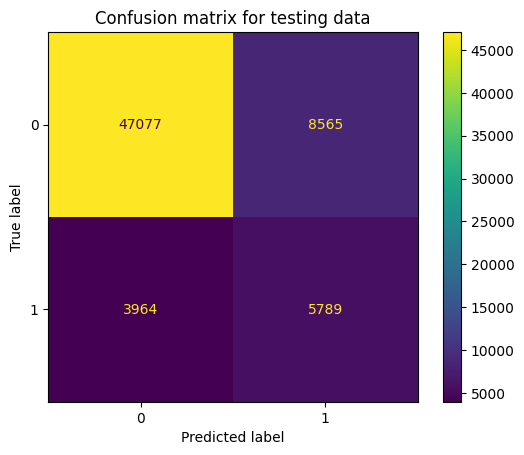

Classification report for testing data is below:
              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88     55642
         1.0       0.40      0.59      0.48      9753

    accuracy                           0.81     65395
   macro avg       0.66      0.72      0.68     65395
weighted avg       0.84      0.81      0.82     65395



In [4]:
# Below lines of code display the confusion matrix and classification report for the hgbc model when tested with unseen data.
test_pred_target = hgbc.predict(X_test1)
ConfusionMatrixDisplay(confusion_matrix(y_test, test_pred_target)).plot()
plt.title('Confusion matrix for testing data')
plt.show()
print('Classification report for testing data is below:')
print(classification_report(y_test, test_pred_target))

**Confusion Matrix Observations**

* Most predictions made by the model were true negatives (non-diabetic individuals).
* The model predicted more non-diabetic individuals as diabetic than it correctly identified diabetic individuals.

**Classification Report Observations**

* Precision, recall, and F1-score are significantly higher for the negative class (non-diabetic) compared to the positive class (diabetic).
* The training data exhibits a clear imbalance, with a significantly larger number of non-diabetic individuals compared to diabetic individuals.

#### Summary

Referencing the classification reports for both the training and testing data, the model generalizes well, as all metrics are approximately the same. This indicates that the model is not overfitting, as it performs similarly on unseen data. However, the primary issue is that the scores do not align with the main objective of correctly predicting diabetic individuals.

If the goal were to maximize the f1-score for non-diabetic individuals, the model’s performance would be satisfactory, and we could consider moving toward deployment. However, since the focus is on identifying diabetic individuals (f1-score for the positive class), the low performance in this area is concerning. A significant contributing factor to this is likely the severe class imbalance in the dataset. With a disproportionately larger number of non-diabetic instances, the model learns to identify their characteristics more effectively, while the limited data for diabetic individuals hampers its ability to distinguish this class.

From the beginning, one strategy I have employed to address this imbalance is using the class_weight or scale_pos_weight parameters. As observed in 'first model building process.ipynb', incorporating these parameters has consistently improved the F1 score for the positive class. However, the improvements, while measurable, have not been substantial enough to make a meaningful impact.

### XGB Classifier

In [7]:
# Importing XGBClassifier function.
from xgboost import XGBClassifier

#### Training XGBClassifier

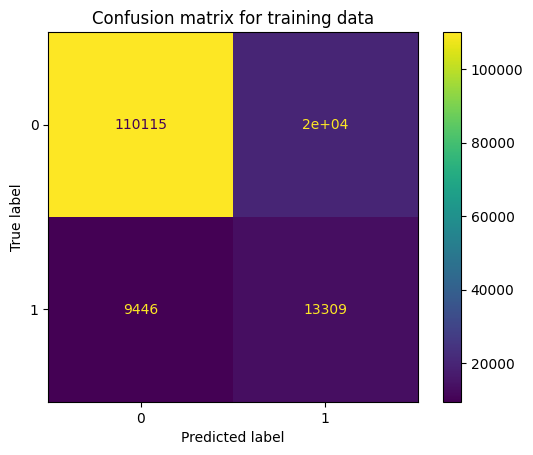

Classification report for training data is below:
              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88    129831
         1.0       0.40      0.58      0.48     22755

    accuracy                           0.81    152586
   macro avg       0.66      0.72      0.68    152586
weighted avg       0.84      0.81      0.82    152586



In [6]:
# Creating a XGBClassifier model, xgbc, with the best parameters determined from the best XGBClassifier model in 'a second attempt.ipynb'.
xgbc = XGBClassifier(random_state=42, scale_pos_weight = 3, max_depth=2, gamma=0.1, eta=0.3)
# Fitting xgbc with training data.
xgbc.fit(X_train1, y_train)

# Below lines of code display the confusion matrix and classification report for the xgbc model when tested with the training data.
train_pred_target = xgbc.predict(X_train1)
ConfusionMatrixDisplay(confusion_matrix(y_train, train_pred_target)).plot()
plt.title('Confusion matrix for training data')
plt.show()
print('Classification report for training data is below:')
print(classification_report(y_train, train_pred_target))

Observations are the exact same as the HistGradientBoostingClassifier

**Confusion Matrix Observations**

* Most predictions made by the model were true negatives (non-diabetic individuals).
* The model predicted more non-diabetic individuals as diabetic than it correctly identified diabetic individuals.

**Classification Report Observations**

* Precision, recall, and F1-score are significantly higher for the negative class (non-diabetic) compared to the positive class (diabetic).
* The training data exhibits a clear imbalance, with a significantly larger number of non-diabetic individuals compared to diabetic individuals.

#### Testing XGBClassifier

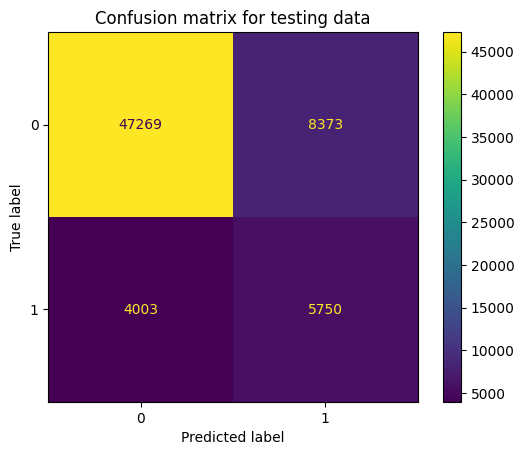

Classification report for testing data is below:
              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88     55642
         1.0       0.41      0.59      0.48      9753

    accuracy                           0.81     65395
   macro avg       0.66      0.72      0.68     65395
weighted avg       0.85      0.81      0.82     65395



In [7]:
# Below lines of code display the confusion matrix and classification report for the xgbc model when tested with unseen data.
test_pred_target = xgbc.predict(X_test1)
ConfusionMatrixDisplay(confusion_matrix(y_test, test_pred_target)).plot()
plt.title('Confusion matrix for testing data')
plt.show()
print('Classification report for testing data is below:')
print(classification_report(y_test, test_pred_target))

Observations are the exact same as the HistGradientBoostingClassifier.

**Confusion Matrix Observations**

* Most predictions made by the model were true negatives (non-diabetic individuals).
* The model predicted more non-diabetic individuals as diabetic than it correctly identified diabetic individuals.

**Classification Report Observations**

* Precision, recall, and F1-score are significantly higher for the negative class (non-diabetic) compared to the positive class (diabetic).
* The training data exhibits a clear imbalance, with a significantly larger number of non-diabetic individuals compared to diabetic individuals.

#### Summary

Since the output is approximately identical, what applied in the summary for the HistGradientBoostingClassifier is the same here.

## Next Steps

#### Adjusting threshold

I initially planned to use the TunedThresholdClassifierCV function from sklearn.model_selection, but it appears that this function is not part of the library. The idea was to input my classifier, specify the scoring metric to optimize, and provide the training data. The function would then determine the optimal probability threshold that maximizes the specified scoring metric. Unfortunately, since this function is unavailable, I'll need to explore alternative approaches.

In [5]:
from sklearn.metrics import f1_score, recall_score, precision_score
import seaborn as sns

##### XGBClassifier

0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.6500000000000001, 0.7000000000000001, 0.7500000000000001, 0.8, 0.8500000000000001, 0.9000000000000001, 

c:\Users\conno\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9500000000000001, 

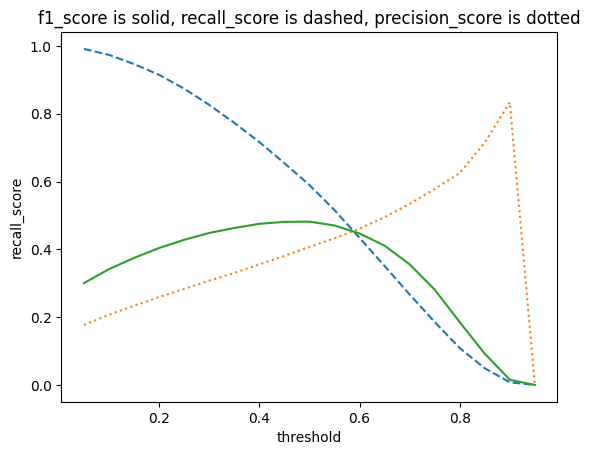


   threshold  f1_score  recall_score  precision_score
9        0.5  0.481655      0.589562         0.407137


In [33]:
# Creating thres data frame.
thres = pd.DataFrame(columns=['threshold','f1_score', 'recall_score','precision_score'])

for i in np.arange(0.05, 1, 0.05):
    # Creating a XGBClassifier model, xgbc, with the best parameters determined from the best XGBClassifier model in 'a second attempt.ipynb'.
    xgbc = XGBClassifier(random_state=42, scale_pos_weight = 3, max_depth=2, gamma=0.1, eta=0.3)
    # Fitting xgbc with training data.
    xgbc.fit(X_train1, y_train)
    # Predicting target values via given threshold level, i.
    pred_test_prob = xgbc.predict_proba(X_test1)[:,1]
    pred_test_target = (pred_test_prob > i).astype(int)
    # Calculating f1_score, recall_score, and precision_score.
    f1_test = f1_score(y_test, pred_test_target)
    recall_test = recall_score(y_test, pred_test_target)
    precision_test = precision_score(y_test, pred_test_target)
    # Updating our thres data frame to hold given threshold, f1_score, recall_score, and precision_score.
    thres.loc[len(thres.index)] = [i, f1_test, recall_test, precision_test]

    # Process update
    print(i, end=', ')

# Plotting the scores for precision, recall, and f1 versus the threshold.
sns.lineplot(x=thres['threshold'], y=thres['recall_score'], linestyle='dashed')
sns.lineplot(x=thres['threshold'], y=thres['precision_score'], linestyle='dotted')
sns.lineplot(x=thres['threshold'], y=thres['f1_score'])
plt.title('f1_score is solid, recall_score is dashed, precision_score is dotted')
plt.show()

print()
print(thres.sort_values(by='f1_score', ascending=False).head(1))

The graph shows the relationship between the threshold (x-axis) and the scores for F1, recall, and precision (y-axis).

* At low thresholds (left side of the graph), recall is highest, approaching 1. However, precision is very low (less than 0.2), resulting in a relatively poor f1_score.
* As the threshold increases, recall decreases while precision increases. This leads to a rise in the f1_score, which reflects the balance between precision and recall.
* All three metrics eventually converge around a threshold of 0.55, where their scores are approximately 0.41. Beyond this threshold, the precision rises sharply, recall drops significantly, and the f1_score begins to decline.

We also learned that the best f1_score came when the threshold was 0.5

##### HistGradientBoostingClassifier

0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.6500000000000001, 0.7000000000000001, 0.7500000000000001, 0.8, 0.8500000000000001, 0.9000000000000001, 

c:\Users\conno\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9500000000000001, 

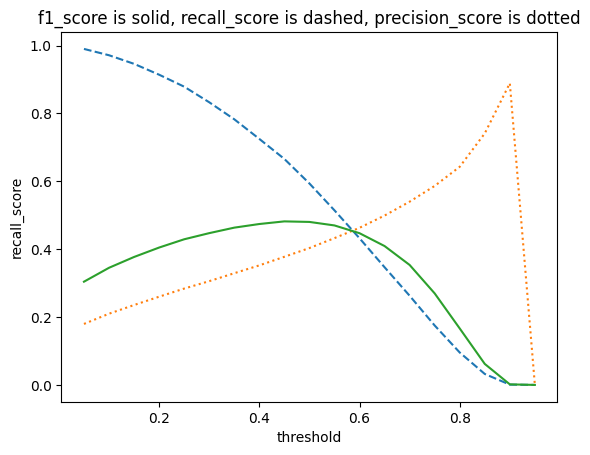


   threshold  f1_score  recall_score  precision_score
8       0.45  0.481894      0.665846          0.37758


In [34]:
# Creating thres data frame.
thres = pd.DataFrame(columns=['threshold','f1_score', 'recall_score','precision_score'])

for i in np.arange(0.05, 1, 0.05):
    # Creating a HistGradientBoostingClassifier model, hgbc, with the best parameters determined from the best HistGradientBoostingClassifier model in 'a second attempt.ipynb'.
    hgbc = HistGradientBoostingClassifier(random_state=42, min_samples_leaf=5, max_leaf_nodes=15,
                                        max_iter=100, max_depth=20, learning_rate=.1,
                                        l2_regularization=0.5, class_weight={0:1, 1:3})
    # Fitting hgbc with training data.
    hgbc.fit(X_train1, y_train)
    # Predicting target values via given threshold, i.
    pred_test_prob = hgbc.predict_proba(X_test1)[:,1]
    pred_test_target = (pred_test_prob > i).astype(int)
    # Calculating f1_score, recall_score, and precision_score.
    f1_test = f1_score(y_test, pred_test_target)
    recall_test = recall_score(y_test, pred_test_target)
    precision_test = precision_score(y_test, pred_test_target)
    # Updating our thres data frame to hold given threshold, f1_score, recall_score, and precision_score.
    thres.loc[len(thres.index)] = [i, f1_test, recall_test, precision_test]
    
    # Process update
    print(i, end=', ')

# Plotting the scores for precision, recall, and f1 versus the threshold.
sns.lineplot(x=thres['threshold'], y=thres['recall_score'], linestyle='dashed')
sns.lineplot(x=thres['threshold'], y=thres['precision_score'], linestyle='dotted')
sns.lineplot(x=thres['threshold'], y=thres['f1_score'])
plt.title('f1_score is solid, recall_score is dashed, precision_score is dotted')
plt.show()

print()
print(thres.sort_values(by='f1_score', ascending=False).head(1))

For all intents and purposes, the same characteristics observed in the XGBClassifier graph apply here as well. At a low threshold, recall is very high, but the f1_score is poor due to precision being less than 0.2. As the threshold increases, precision improves while recall decreases, resulting in a temporary rise in the f1_score. Eventually, the f1_score starts to decline before approximately converging with precision and recall at a threshold of approximately 0.55. Beyond this point, the f1_score and recall continue to decrease while precision increases, before ultimately experiencing a steep drop.

We also learned that the best f1_score came when the threshold was  0.45.

##### Conclusion for Adjusting Threshold

There was no magic threshold that magically skyrockets the f1_score.

### SMOTE

#### Oversampling

In [1]:
from imblearn.over_sampling import SMOTE

In [6]:
print(y_train.value_counts())
X_train1_sm, y_train_sm = SMOTE(random_state=22).fit_resample(X_train1, y_train)
print(y_train_sm.value_counts())

diabetes_status
0.0    129831
1.0     22755
Name: count, dtype: int64
diabetes_status
0.0    129831
1.0    129831
Name: count, dtype: int64


After resampling our training sets, we can tell that now both the positive and negative class have the same number of instances compared to the initial training set.

In [40]:
# Creating a HistGradientBoostingClassifier model, hgbc, with random state.
hgbc = HistGradientBoostingClassifier(random_state=42)
# Fitting hgbc with training data.
hgbc.fit(X_train1_sm, y_train_sm)

# Printing the classification report for the hgbc model when tested with the training data. 
train_pred_target = hgbc.predict(X_train1_sm)
print('Classification report for training data is below:')
print(classification_report(y_train_sm, train_pred_target))

# Printing the classification report for the hgbc model when tested with the testing data.
test_pred_target = hgbc.predict(X_test1)
print('Classification report for training data is below:')
print(classification_report(y_test, test_pred_target))

Classification report for training data is below:
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91    129831
         1.0       0.96      0.86      0.90    129831

    accuracy                           0.91    259662
   macro avg       0.91      0.91      0.91    259662
weighted avg       0.91      0.91      0.91    259662

Classification report for training data is below:
              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92     55642
         1.0       0.53      0.24      0.33      9753

    accuracy                           0.86     65395
   macro avg       0.71      0.60      0.63     65395
weighted avg       0.83      0.86      0.83     65395



For the negative class, the model generalizes perfectly. However, it performs poorly for the class that actually matters. With the f1_score dropping from 0.90 to 0.33, it’s evident that something is fundamentally wrong with the model. One possible explanation is that while the training data provides equal representation for both classes, the testing data does not. This discrepancy might leave the model unable to adapt, resulting in poor generalization to the underrepresented class in the testing set.

In [41]:
# Creating a XGBClassifier model, xgbc, with random state.
xgbc = XGBClassifier(random_state=42)
# Fitting hgbc with training data.
xgbc.fit(X_train1_sm, y_train_sm)

# Printing the classification report for the xgbc model when tested with the training data. 
train_pred_target = xgbc.predict(X_train1_sm)
print('Classification report for training data is below:')
print(classification_report(y_train_sm, train_pred_target))

# Printing the classification report for the xgbc model when tested with the testing data.
test_pred_target = xgbc.predict(X_test1)
print('Classification report for training data is below:')
print(classification_report(y_test, test_pred_target))

Classification report for training data is below:
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92    129831
         1.0       0.97      0.86      0.91    129831

    accuracy                           0.92    259662
   macro avg       0.92      0.92      0.92    259662
weighted avg       0.92      0.92      0.92    259662

Classification report for training data is below:
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92     55642
         1.0       0.55      0.22      0.31      9753

    accuracy                           0.86     65395
   macro avg       0.71      0.59      0.62     65395
weighted avg       0.83      0.86      0.83     65395



These results are nearly identical to those of the HGBC model, with the model performing poorly on the most critical metric: the f1_score for the positive class.

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

In [51]:
# Creating list to house dictionary of possible parameter values.
param_dist = [{
    'learning_rate': [.1, .5],
    'max_iter': [25, 50, 100],
    'max_leaf_nodes': [5, 15],
    'max_depth': [5,10],
    'min_samples_leaf': [5,10],
    'l2_regularization': [.1, .5, 1],
    'class_weight': [{0:1, 1:w} for w in [1, 3, 5.69]]
}]

# Creating initial HistGradientBoostingClassifier model.
hgbc = HistGradientBoostingClassifier(random_state=42)
# Creating initial RandomizedSearchCV function.
rand_search = RandomizedSearchCV(hgbc, param_distributions=param_dist, 
                                scoring= make_scorer(f1_score, pos_label=1),
                                cv=4, 
                                verbose=1, n_iter=43, random_state=22)
# Fitting rand_search with training data.
rand_search.fit(X_train1_sm, y_train_sm)

# Printing the best parameters from the best estimator from rand_search.
print(rand_search.best_params_)
print(rand_search.best_score_)

Fitting 4 folds for each of 43 candidates, totalling 172 fits
{'min_samples_leaf': 10, 'max_leaf_nodes': 15, 'max_iter': 100, 'max_depth': 5, 'learning_rate': 0.5, 'l2_regularization': 0.1, 'class_weight': {0: 1, 1: 1}}
0.8398639465765517


In [52]:
# Creating a HistGradientBoostingClassifier model, hgbc, with random state and the best parameters from the best estimator from rand_search.
hgbc = rand_search.best_estimator_
# Fitting hgbc with training data.
hgbc.fit(X_train1_sm, y_train_sm)

# Printing the classification report for the hgbc model when tested with the training data. 
train_pred_target = hgbc.predict(X_train1_sm)
print('Classification report for training data is below:')
print(classification_report(y_train_sm, train_pred_target))

# Printing the classification report for the hgbc model when tested with the testing data.
test_pred_target = hgbc.predict(X_test1)
print('Classification report for testing data is below:')
print(classification_report(y_test, test_pred_target))

Classification report for training data is below:
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92    129831
         1.0       0.97      0.86      0.91    129831

    accuracy                           0.92    259662
   macro avg       0.92      0.92      0.91    259662
weighted avg       0.92      0.92      0.91    259662

Classification report for testing data is below:
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92     55642
         1.0       0.54      0.22      0.32      9753

    accuracy                           0.86     65395
   macro avg       0.71      0.59      0.62     65395
weighted avg       0.83      0.86      0.83     65395



The issue I’m encountering with using the RandomizedSearchCV function is that it trains and selects the best estimator based on the highest F1 score for the positive class. However, since the training data differs significantly from the testing data, this likely explains why the best F1 score exceeds 0.80 on the training data but drops to 0.32 on the testing data.

What still bothers me is that I removed the StratifiedKFold function, meaning the target values could be unevenly distributed across the cross-validation folds. Perhaps I need to generate more cross-validation sets to address this issue. However, this would also take more time.

In [53]:
# Creating list to house dictionary with possible parameter values.
param_dist = [{
    'eta': [0.1, 0.3, 0.7],
    'gamma': [0.1, 0.4],
    'max_depth': [2, 6, 9,],
    'scale_pos_weight': [1, 3, 5.69]
}]
# Creating initial XGBClassifier model.
xgbc = XGBClassifier(random_state=42)
# Creating RandomizedSearchCV function.
rand_search = RandomizedSearchCV(xgbc, param_distributions=param_dist, 
                                scoring=make_scorer(f1_score, pos_label=1), 
                                cv=4, 
                                verbose=1, random_state=22)
# Fitting rand_search with training data.
rand_search.fit(X_train1_sm, y_train_sm)

# Printing the best parameters from the best estimator from rand_search.
print(rand_search.best_params_)
print(rand_search.best_score_)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


{'scale_pos_weight': 1, 'max_depth': 6, 'gamma': 0.4, 'eta': 0.3}
0.8431066996376577


In [54]:
# Creating a XGBClassifier model, xgbc, with random state and best parameters from the best estimator from rand_search.
xgbc = rand_search.best_estimator_
# Fitting hgbc with training data.
xgbc.fit(X_train1_sm, y_train_sm)

# Printing the classification report for the xgbc model when tested with the training data. 
train_pred_target = xgbc.predict(X_train1_sm)
print('Classification report for training data is below:')
print(classification_report(y_train_sm, train_pred_target))

# Printing the classification report for the xgbc model when tested with the testing data.
test_pred_target = xgbc.predict(X_test1)
print('Classification report for training data is below:')
print(classification_report(y_test, test_pred_target))

Classification report for training data is below:
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92    129831
         1.0       0.97      0.87      0.92    129831

    accuracy                           0.92    259662
   macro avg       0.93      0.92      0.92    259662
weighted avg       0.93      0.92      0.92    259662

Classification report for training data is below:
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92     55642
         1.0       0.55      0.22      0.31      9753

    accuracy                           0.86     65395
   macro avg       0.71      0.59      0.62     65395
weighted avg       0.83      0.86      0.83     65395



The same issue that affected the HGBC model occurs here as well: it seems nearly pointless to use the RandomizedSearchCV function when the testing data differs significantly from the training data. While it’s encouraging to see the model perform well on both classes in the training data, this doesn’t hold much value when the testing score is poor.

#### Combined

In [2]:
from imblearn.combine import SMOTEENN

In [3]:
print(y_train.value_counts())
X_train1_sm_c, y_train_sm_c = SMOTEENN(random_state=22).fit_resample(X_train1, y_train)
print(y_train_sm_c.value_counts())

diabetes_status
0.0    129831
1.0     22755
Name: count, dtype: int64
diabetes_status
1.0    121704
0.0     79563
Name: count, dtype: int64


In [ ]:
# Creating list to house dictionary of possible parameter values.
param_dist = [{
    'learning_rate': [.1, .5],
    'max_iter': [25, 50, 100],
    'max_leaf_nodes': [5, 15],
    'max_depth': [5,10],
    'min_samples_leaf': [5,10],
    'l2_regularization': [.1, .5, 1],
    'class_weight': [{0:1, 1:w} for w in [1, 3, 5.69]]
}]

# Creating initial HistGradientBoostingClassifier model.
hgbc = HistGradientBoostingClassifier(random_state=42)
# Creating initial RandomizedSearchCV function.
rand_search = RandomizedSearchCV(hgbc, param_distributions=param_dist, 
                                scoring= make_scorer(f1_score, pos_label=1),
                                cv=5, 
                                verbose=1, n_iter=43, random_state=22)
# Fitting rand_search with training data.
rand_search.fit(X_train1_sm_c, y_train_sm_c)

# Printing the best parameters from the best estimator from rand_search.
print(rand_search.best_params_)
print(rand_search.best_score_)

Fitting 5 folds for each of 43 candidates, totalling 215 fits
{'min_samples_leaf': 5, 'max_leaf_nodes': 15, 'max_iter': 50, 'max_depth': 10, 'learning_rate': 0.1, 'l2_regularization': 0.5, 'class_weight': {0: 1, 1: 1}}
0.9185659256800671


NameError: name 'X_train1_sm' is not defined

In [11]:
# Creating a HistGradientBoostingClassifier model, hgbc, with random state and the best parameters from the best estimator from rand_search.
hgbc = rand_search.best_estimator_
# Fitting hgbc with training data.
hgbc.fit(X_train1_sm_c, y_train_sm_c)

# Printing the classification report for the hgbc model when tested with the training data. 
train_pred_target = hgbc.predict(X_train1_sm_c)
print('Classification report for training data is below:')
print(classification_report(y_train_sm_c, train_pred_target))

# Printing the classification report for the hgbc model when tested with the testing data.
test_pred_target = hgbc.predict(X_test1)
print('Classification report for testing data is below:')
print(classification_report(y_test, test_pred_target))

Classification report for training data is below:
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90     79563
         1.0       0.93      0.94      0.93    121704

    accuracy                           0.92    201267
   macro avg       0.92      0.92      0.92    201267
weighted avg       0.92      0.92      0.92    201267

Classification report for testing data is below:
              precision    recall  f1-score   support

         0.0       0.94      0.75      0.84     55642
         1.0       0.34      0.74      0.47      9753

    accuracy                           0.75     65395
   macro avg       0.64      0.75      0.65     65395
weighted avg       0.85      0.75      0.78     65395



While the F1 score is better here than when the minority class was over-sampled, it is still far from satisfactory.

In [12]:
# Creating list to house dictionary with possible parameter values.
param_dist = [{
    'eta': [0.1, 0.3, 0.7],
    'gamma': [0.1, 0.4],
    'max_depth': [2, 6, 9,],
    'scale_pos_weight': [1, 3, 5.69]
}]
# Creating initial XGBClassifier model.
xgbc = XGBClassifier(random_state=42)
# Creating RandomizedSearchCV function.
rand_search = RandomizedSearchCV(xgbc, param_distributions=param_dist, 
                                scoring=make_scorer(f1_score, pos_label=1), 
                                cv=5, 
                                verbose=1, random_state=22)
# Fitting rand_search with training data.
rand_search.fit(X_train1_sm_c, y_train_sm_c)

# Printing the best parameters from the best estimator from rand_search.
print(rand_search.best_params_)
print(rand_search.best_score_)



# Creating a XGBClassifier model, xgbc, with random state and best parameters from the best estimator from rand_search.
xgbc = rand_search.best_estimator_
# Fitting hgbc with training data.
xgbc.fit(X_train1_sm_c, y_train_sm_c)

# Printing the classification report for the xgbc model when tested with the training data. 
train_pred_target = xgbc.predict(X_train1_sm_c)
print('Classification report for training data is below:')
print(classification_report(y_train_sm_c, train_pred_target))

# Printing the classification report for the xgbc model when tested with the testing data.
test_pred_target = xgbc.predict(X_test1)
print('Classification report for training data is below:')
print(classification_report(y_test, test_pred_target))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'scale_pos_weight': 1, 'max_depth': 6, 'gamma': 0.4, 'eta': 0.1}
0.9046712710902887
Classification report for training data is below:
              precision    recall  f1-score   support

         0.0       0.92      0.93      0.93     79563
         1.0       0.96      0.95      0.95    121704

    accuracy                           0.94    201267
   macro avg       0.94      0.94      0.94    201267
weighted avg       0.94      0.94      0.94    201267

Classification report for training data is below:
              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86     55642
         1.0       0.37      0.68      0.48      9753

    accuracy                           0.78     65395
   macro avg       0.65      0.74      0.67     65395
weighted avg       0.85      0.78      0.80     65395



Once again, the F1 score here is better than when the minority class was over-sampled, but it still falls short of being satisfactory.

# Conclusion

At this point in the project, I am finding it hard to keep going. There is nothing I want more at the moment—besides securing a full-time job—than getting this project right. The issue I am facing, however, is that due to the severe class imbalance, I am not sure I will ever be able to find a single model or combination of models that achieves the F1 score I desire. This is extremely frustrating because I know that if I were to instead focus solely on recall or precision, I would already have a final product.

Personally, I would prioritize ensuring the model accurately identifies diabetic individuals (high recall). However, this approach wouldn’t be effective in the long run if resources were to run out, as the model might end up predicting too many individuals as diabetic, thereby depleting those resources. The F1 score is designed to strike a harmonic balance between recall and precision, but achieving that balance in this project feels increasingly unattainable.

Additionally, focusing solely on recall feels like taking the easy way out. While it would be better than abandoning the project altogether, it wouldn’t be as rewarding as figuring out how to achieve a high F1 score.